In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import glob
import os
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.models import Sequential ,load_model
from keras.optimizers import Adam
from keras import callbacks
from keras.layers import Flatten,Dense

In [ ]:
!unzip -uq "/content/drive/MyDrive/dataset/Brain tumor segmentation.zip"

Preparing Data

In [ ]:
root_path ="/content/lgg-mri-segmentation/kaggle_3m/"

all_files = glob.glob(root_path + "*/*.tif") # names of all the files
print(len(all_files))

mask_files =glob.glob(root_path + "*/*_mask.tif")
print(len(mask_files))

image_files=[]

for mask in mask_files:
  rmask = mask.replace("_mask","")
  image_files.append(rmask)

print(len(image_files))

7858
3929
3929


In [ ]:
def diagnosis(path):
  if np.max(cv2.imread(path))>0:
    return 1
  else:
    return 0

data =pd.DataFrame({'image_path':image_files,
                    'mask_files':mask_files,
                    'diagnosis':[diagnosis(x) for x in mask_files]})

In [ ]:
data.head()

,image_path,mask_files,diagnosis
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1


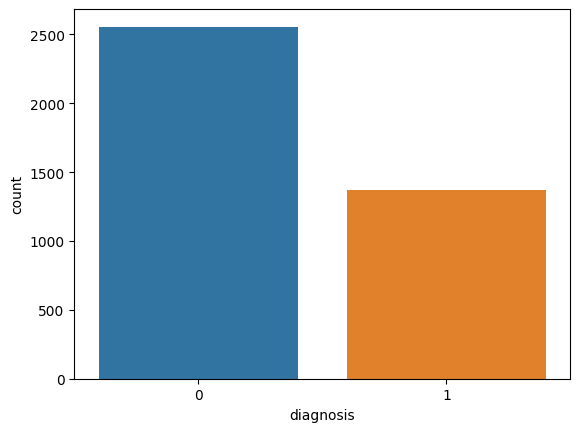

In [ ]:
sns.countplot(x='diagnosis',data =data)
plt.show()

In [ ]:
data.diagnosis.value_counts()

0    2556
1    1373
Name: diagnosis, dtype: int64

Handling imbalanced data

In [ ]:
df = data.sort_values('diagnosis',ascending= True)
new_data = df.drop(df.head(500).index,axis=0)

In [ ]:
final_data =shuffle(new_data).reset_index(drop=True)
final_data['diagnosis'] = final_data['diagnosis'].astype(str)

In [ ]:
final_data.head()

,image_path,mask_files,diagnosis
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,0
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1


Data Visualisation

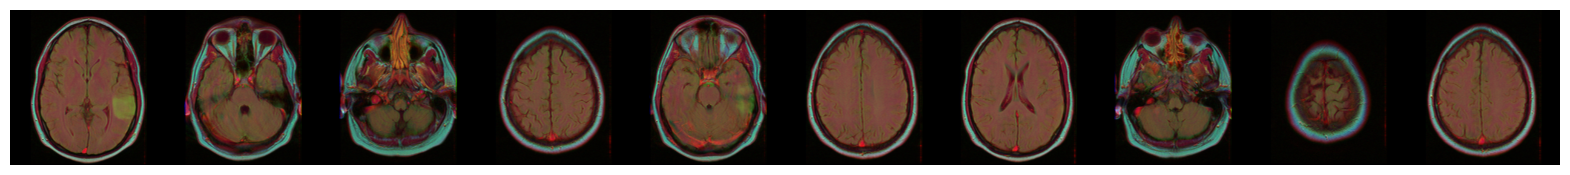

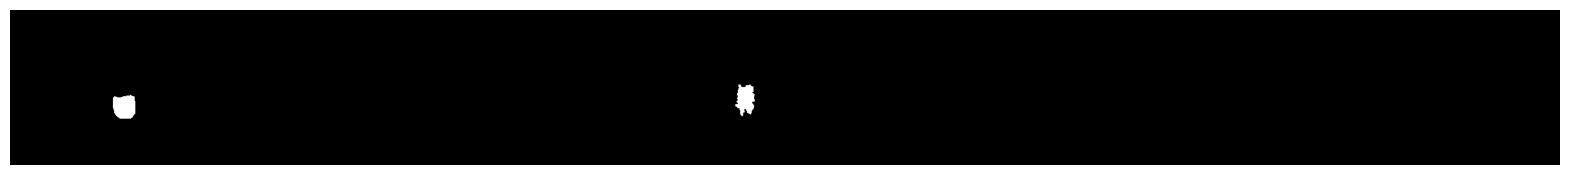

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(len(image_files[:10])):
  plt.subplot(1, 10, i+1)
  image = cv2.imread(image_files[i])
  plt.imshow(image)
  plt.axis('off')
  plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

plt.figure(figsize=(20, 20))
for i in range(len(mask_files[:10])):
  plt.subplot(2, 10, i+1)
  mask = cv2.imread(mask_files[i])
  plt.imshow(mask)
  plt.axis('off')
  plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Data Augmentation

In [ ]:
train_data ,val_data =train_test_split(final_data,test_size =0.2,random_state=42)
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

In [ ]:
data_gen =ImageDataGenerator(
    rescale =1/255.0,
    rotation_range=10,
    width_shift_range=0.5,
    height_shift_range=0.5,
    zoom_range =0.2,
    horizontal_flip=True
)

test_gen =ImageDataGenerator(rescale=1/255.0)

In [ ]:
train = data_gen.flow_from_dataframe(dataframe=train_data,x_col='image_path',y_col='diagnosis',target_size=(128,128),class_mode="binary")
val = test_gen.flow_from_dataframe(dataframe=val_data,x_col='image_path',y_col='diagnosis',target_size=(128,128),class_mode="binary")

Found 2743 validated image filenames belonging to 2 classes.
Found 686 validated image filenames belonging to 2 classes.


Pretrained Model

In [ ]:
from keras.applications.vgg16 import VGG16

conv_base =VGG16(
    weights ='imagenet',
    include_top=False,
    input_shape =(128,128,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
adam =Adam(learning_rate=0.0001)
earlystopping = callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)
model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
hist =model.fit(train,epochs=20,validation_data=val,callbacks=[earlystopping])

Epoch 1/20
86/86 [==============================] - 39s 275ms/step - loss: 0.4757 - accuracy: 0.7532 - val_loss: 0.3544 - val_accuracy: 0.8397
Epoch 2/20
86/86 [==============================] - 21s 241ms/step - loss: 0.4027 - accuracy: 0.7845 - val_loss: 0.3004 - val_accuracy: 0.8484
Epoch 3/20
86/86 [==============================] - 21s 248ms/step - loss: 0.3391 - accuracy: 0.8378 - val_loss: 0.2656 - val_accuracy: 0.8921
Epoch 4/20
86/86 [==============================] - 22s 259ms/step - loss: 0.3320 - accuracy: 0.8425 - val_loss: 0.2850 - val_accuracy: 0.8528
Epoch 5/20
86/86 [==============================] - 21s 241ms/step - loss: 0.3121 - accuracy: 0.8556 - val_loss: 0.2447 - val_accuracy: 0.8980
Epoch 6/20
86/86 [==============================] - 23s 261ms/step - loss: 0.2883 - accuracy: 0.8688 - val_loss: 0.2716 - val_accuracy: 0.8834
Epoch 7/20
86/86 [==============================] - 21s 239ms/step - loss: 0.2798 - accuracy: 0.8677 - val_loss: 0.2158 - val_accuracy: 0.9125

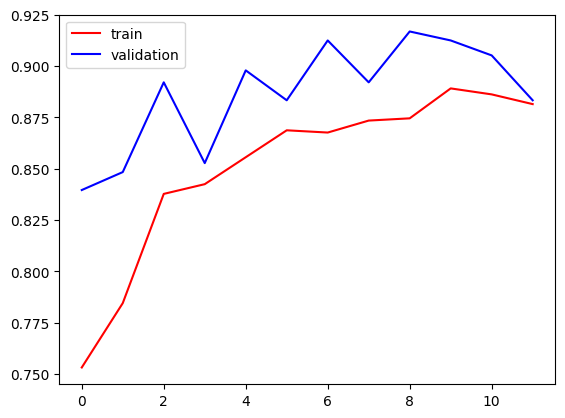

In [ ]:
plt.plot(hist.history['accuracy'],color='red',label='train')
plt.plot(hist.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

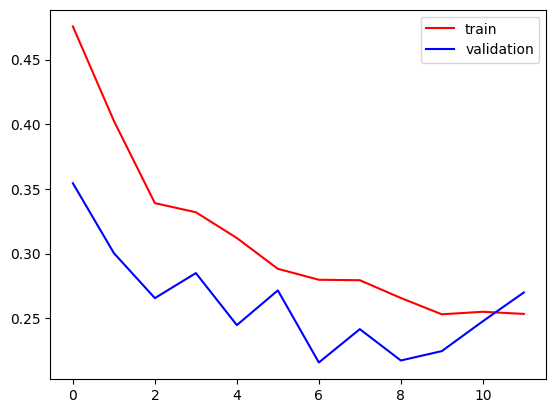

In [ ]:
plt.plot(hist.history['loss'],color='red',label='train')
plt.plot(hist.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/Saved models/BrainTumor.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model =load_model("/content/drive/MyDrive/Saved models/BrainTumor.h5")

In [ ]:
model.evaluate(val)

22/22 [==============================] - 16s 135ms/step - loss: 0.1795 - accuracy: 0.9300


[0.17949876189231873, 0.9300291538238525]

Image Prediction

1/1 [==============================] - 0s 20ms/step


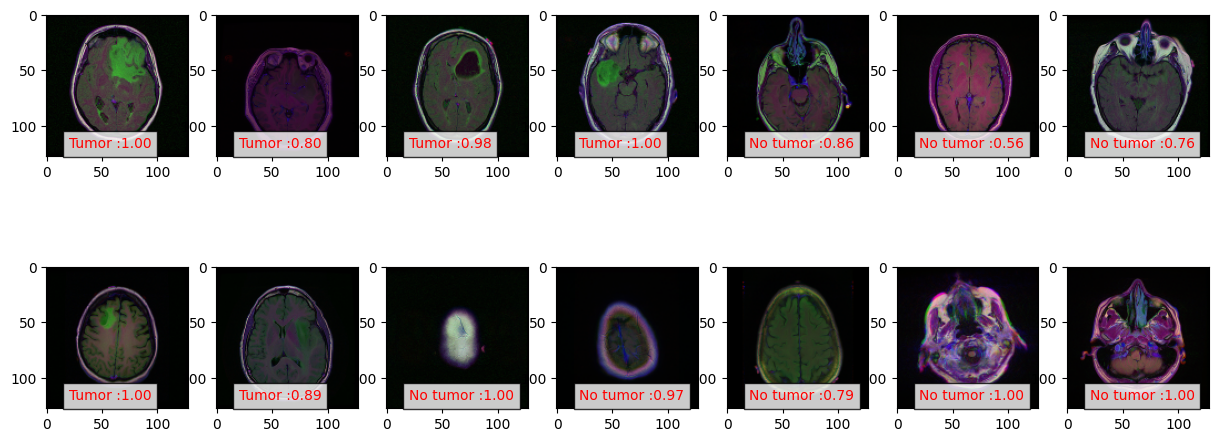

In [ ]:
fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 2
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img1 = load_img(val_data.image_path[np.random.choice(range(100))], target_size=(128, 128))
    img2 = img_to_array(img1)
    img2 = img2/255.0
    img2 = np.expand_dims(img2, axis=0)
    prediction =model.predict(img2)
    if (prediction[:,:]>0.5):
      value ='Tumor :%1.2f'%(prediction[0,0])
      plt.text(20, 120,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    else:
      value ='No tumor :%1.2f'%(1.0-prediction[0,0])
      plt.text(20, 120,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    plt.imshow(img1)